In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

ImportError: cannot import name 'triu' from 'scipy.linalg' (C:\Users\PBS\anaconda3\Lib\site-packages\scipy\linalg\__init__.py)

In [28]:
STOPWORDS = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves',
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about',
    'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up',
    'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when',
    'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no',
    'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should',
    'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven',
    'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'
])

In [29]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = re.findall(r'\b\w+\b', text)
    tokens = [word for word in tokens if word not in STOPWORDS]
    tokens = [word.rstrip('s') if word.endswith('s') else word for word in tokens]
    return ' '.join(tokens)

In [30]:
df = pd.read_csv('bbcnews.csv')

In [31]:
df.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,26,62.17,9.72,It hopes to increase subscribers by offering t...,Its profits were buoyed by one-off gains which...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,17,65.56,9.09,The dollar has hit its highest level against t...,"""I think the chairman's taking a much more san..."
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,14,69.21,9.66,The owners of embattled Russian oil giant Yuko...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profits\n\nBritish A...,business,24,62.98,9.86,Looking ahead to its full year results to Marc...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,17,70.63,10.23,Reports in the Wall Street Journal and the Fin...,Shares in UK drinks and food firm Allied Domec...


In [32]:
df.shape

(2127, 7)

In [33]:
df.isna().sum()

text                            0
labels                          0
no_sentences                    0
Flesch Reading Ease Score       0
Dale-Chall Readability Score    0
text_rank_summary               0
lsa_summary                     0
dtype: int64

In [34]:
df['labels'].value_counts()

labels
sport            505
business         503
politics         403
entertainment    369
tech             347
Name: count, dtype: int64

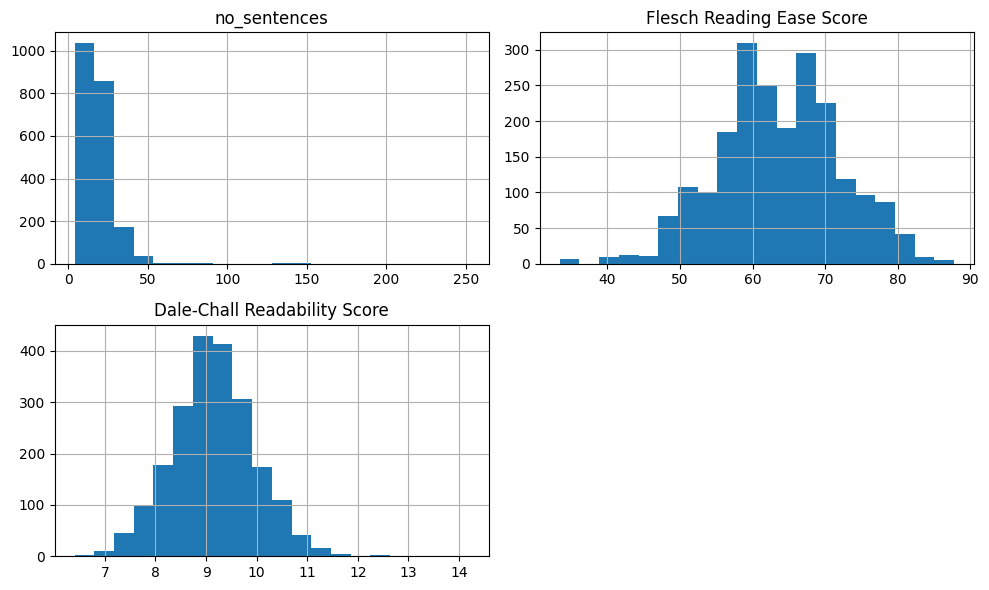

In [59]:
numeric_cols = ['no_sentences', 'Flesch Reading Ease Score', 'Dale-Chall Readability Score']
df[numeric_cols].hist(bins=20, figsize=(10, 6))
plt.tight_layout()
plt.show()

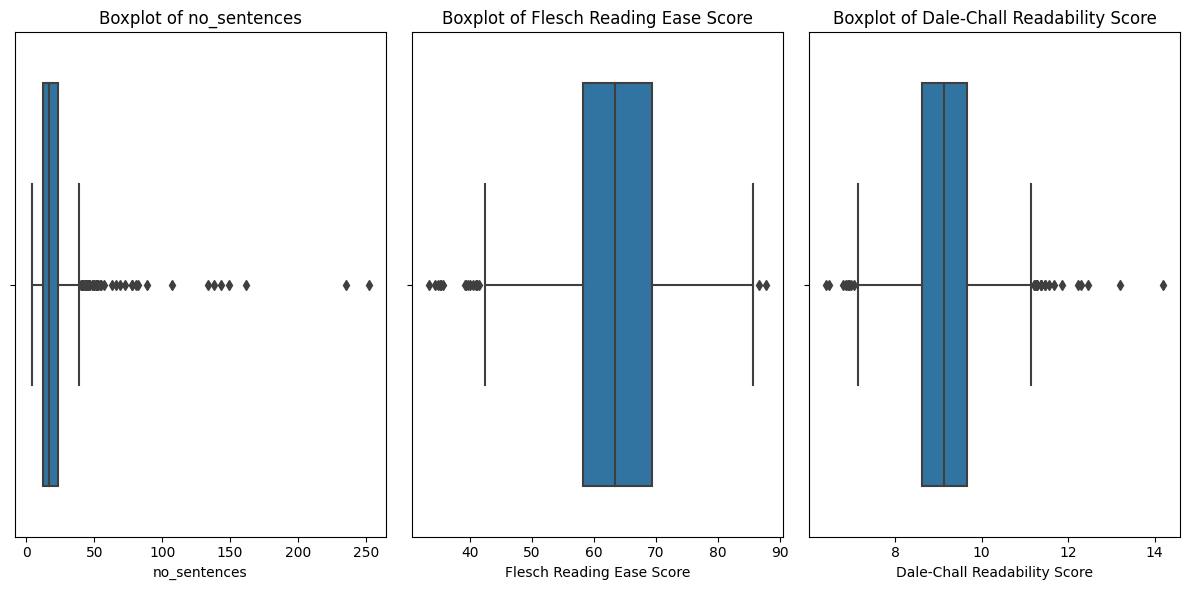

In [62]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

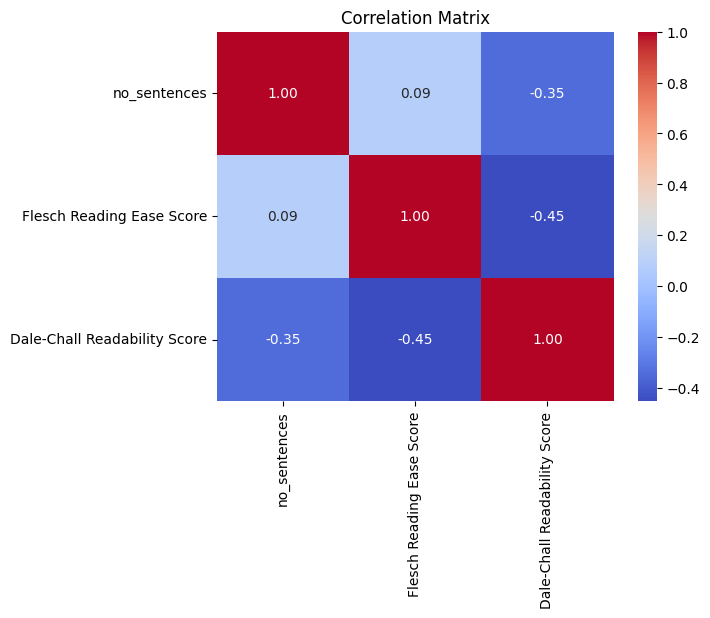

In [64]:
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

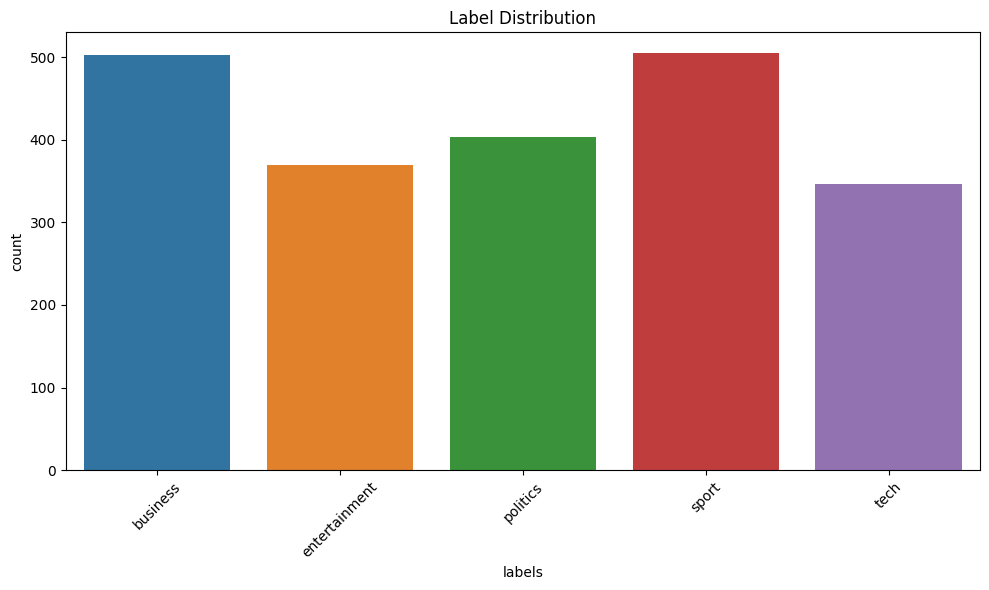

In [65]:
plt.figure(figsize=(10, 6))
sns.countplot(x='labels', data=df)
plt.title('Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [67]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

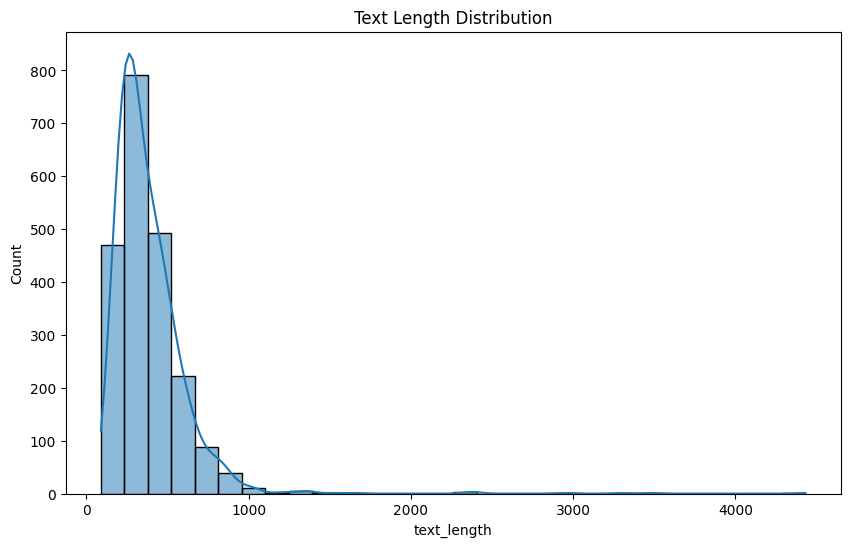

In [68]:
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.show()

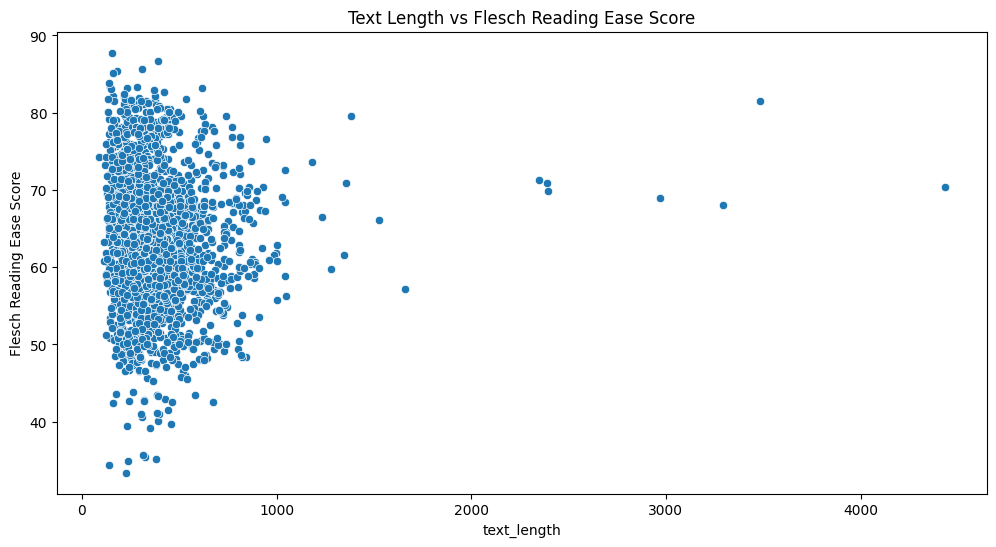

In [69]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='text_length', y='Flesch Reading Ease Score', data=df)
plt.title('Text Length vs Flesch Reading Ease Score')
plt.show()

In [35]:
X = df[['text', 'text_rank_summary', 'lsa_summary']].apply(lambda row: ' '.join(row), axis=1)
X = X.apply(preprocess_text)

In [36]:
y = df['labels']

In [37]:
labelencoder = LabelEncoder()
y_encoded = labelencoder.fit_transform(df['labels'])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

## Using TF-IDF Model

In [39]:
model = make_pipeline(
    TfidfVectorizer(max_features=5000),
    LogisticRegression(max_iter=1000)
)

In [40]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=5000)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [41]:
y_pred = model.predict(X_test)

In [42]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labelencoder.classes_))

Accuracy: 0.9788732394366197

Classification Report:
               precision    recall  f1-score   support

     business       0.99      0.98      0.99       104
entertainment       0.99      0.92      0.95        78
     politics       0.95      1.00      0.97        73
        sport       0.99      1.00      0.99        98
         tech       0.97      0.99      0.98        73

     accuracy                           0.98       426
    macro avg       0.98      0.98      0.98       426
 weighted avg       0.98      0.98      0.98       426



In [43]:
input = 'Professional tennis is one of the most physically demanding and mentally challenging sports in the world. Players are required to perform at their best in a variety of conditions.'

In [44]:
processedinput = preprocess_text(input)

In [45]:
labelencoder.inverse_transform(model.predict([processedinput]))[0]

'sport'

## Using W2V model

In [46]:
corpus = df[['text', 'text_rank_summary', 'lsa_summary']].apply(lambda row: ' '.join(row), axis=1)
corpus = corpus.apply(preprocess_text)

In [47]:
model_w2v = Word2Vec(sentences=corpus, vector_size=300, window=5, min_count=1, workers=4)

In [48]:
def get_average_word2vec(tokens, model, vector_size=300):
    vectors = []
    for word in tokens:
        if word in model.wv:
            vectors.append(model.wv[word])
    
    if len(vectors) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(vectors, axis=0)

In [49]:
X_w2v = np.array([get_average_word2vec(tokens, model_w2v) for tokens in X])

In [52]:
X_trainw2v, X_testw2v, y_trainw2v, y_testw2v = train_test_split(X_w2v, y_encoded, test_size=0.2, random_state=42)

In [53]:
modelw2v = LogisticRegression(max_iter=1000)
modelw2v.fit(X_trainw2v, y_trainw2v)

LogisticRegression(max_iter=1000)

In [55]:
y_predw2v = modelw2v.predict(X_testw2v)

In [56]:
print("Accuracy:", accuracy_score(y_testw2v, y_predw2v))
print("\nClassification Report:")
print(classification_report(y_testw2v, y_predw2v, target_names=labelencoder.classes_))

Accuracy: 0.3685446009389671

Classification Report:
               precision    recall  f1-score   support

     business       0.36      0.75      0.49       104
entertainment       0.00      0.00      0.00        78
     politics       0.00      0.00      0.00        73
        sport       0.38      0.81      0.51        98
         tech       0.00      0.00      0.00        73

     accuracy                           0.37       426
    macro avg       0.15      0.31      0.20       426
 weighted avg       0.18      0.37      0.24       426



C:\Users\L E N O V O\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\L E N O V O\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\L E N O V O\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

## Pre-trained w2v model